In [4]:
!pip install opencv-python


   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB 660.6 kB/s eta 0:01:00
   ---------------------------------------- 0.1/39.5 MB 1.3 MB/s eta 0:00:30
   ---------------------------------------- 0.3/39.5 MB 2.4 MB/s eta 0:00:17
    --------------------------------------- 0.6/39.5 MB 3.5 MB/s eta 0:00:12
    --------------------------------------- 0.9/39.5 MB 4.4 MB/s eta 0:00:09
   - -------------------------------------- 1.3/39.5 MB 5.3 MB/s eta 0:00:08
   -- ------------------------------------- 2.0/39.5 MB 6.7 MB/s eta 0:00:06
   -- ------------------------------------- 2.9/39.5 MB 8.5 MB/s eta 0:00:05
   --- ------------------------------------ 3.9/39.5 MB 9.9 MB/s eta 0:00:04
   ----- ---------------------------------- 5.0/39.5 MB 11.7 MB/s eta 0:00:03
   ----- ---------------------------------- 5.8/39.5 MB 12.4 MB/s eta 0:00:03
   ------

In [6]:
!pip install numpy pandas opencv-python torch torchvision scikit-learn


   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/204.1 MB 5.5 MB/s eta 0:00:38
   ---------------------------------------- 0.4/204.1 MB 6.3 MB/s eta 0:00:33
   ---------------------------------------- 0.9/204.1 MB 8.3 MB/s eta 0:00:25
   ---------------------------------------- 1.6/204.1 MB 9.2 MB/s eta 0:00:23
   ---------------------------------------- 2.3/204.1 MB 11.1 MB/s eta 0:00:19
    --------------------------------------- 2.9/204.1 MB 11.7 MB/s eta 0:00:18
    --------------------------------------- 3.7/204.1 MB 13.2 MB/s eta 0:00:16
    --------------------------------------- 4.5/204.1 MB 13.8 MB/s eta 0:00:15
   - -------------------------------------- 5.2/204.1 MB 14.4 MB/s eta 0:00:14
   - -------------------------------------- 6.3/204.1 MB 15.5 MB/s eta 0:00:13
   - -------------------------------------- 7.2/204.1 MB 15.8 MB/s eta 0:00:13
   - -------------------------------------- 7.7/204.1 MB 15.4 MB

Epoch 1/20
Train Loss: 0.9680
Val Loss: 0.9649
Epoch 2/20
Train Loss: 0.8866
Val Loss: 0.8067
Epoch 3/20
Train Loss: 0.4701
Val Loss: 0.1942
Epoch 4/20
Train Loss: 0.2052
Val Loss: 0.1632
Epoch 5/20
Train Loss: 0.1919
Val Loss: 0.1596
Epoch 6/20
Train Loss: 0.1880
Val Loss: 0.1589
Epoch 7/20
Train Loss: 0.1880
Val Loss: 0.1600
Epoch 8/20
Train Loss: 0.1874
Val Loss: 0.1586
Epoch 9/20
Train Loss: 0.1829
Val Loss: 0.1589
Epoch 10/20
Train Loss: 0.1884
Val Loss: 0.1573
Epoch 11/20
Train Loss: 0.1829
Val Loss: 0.1625
Epoch 12/20
Train Loss: 0.1873
Val Loss: 0.1579
Epoch 13/20
Train Loss: 0.1825
Val Loss: 0.1726
Epoch 14/20
Train Loss: 0.1830
Val Loss: 0.1593
Epoch 15/20
Train Loss: 0.1882
Val Loss: 0.1585
Epoch 16/20
Train Loss: 0.1836
Val Loss: 0.1649
Epoch 17/20
Train Loss: 0.1830
Val Loss: 0.1719
Epoch 18/20
Train Loss: 0.1829
Val Loss: 0.1611
Epoch 19/20
Train Loss: 0.1835
Val Loss: 0.1569
Epoch 20/20
Train Loss: 0.1819
Val Loss: 0.1573


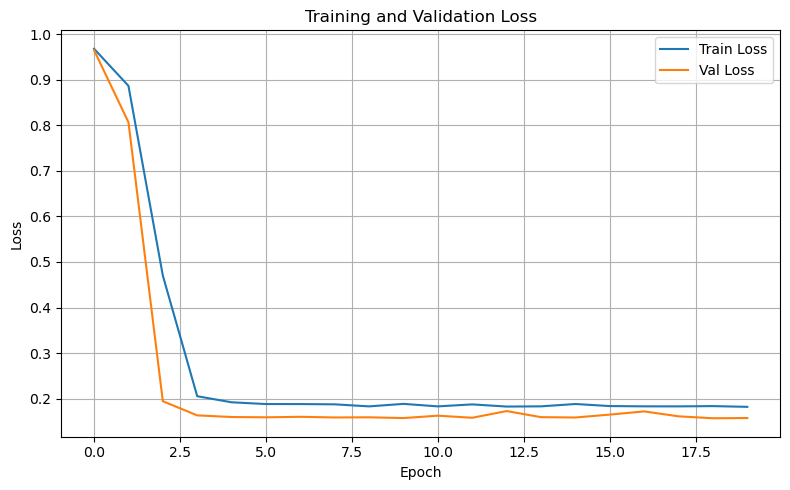

In [5]:
# Brain CT Hemorrhage - Multi-Task Model 

import os
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import ast

#  'brain_bone_window' view
HEMORRHAGE_TYPES = [
    'epidural', 'subdural', 'intraparenchymal', 'subarachnoid', 'intraventricular', 'multi'
]
WINDOW_TYPE = 'brain_bone_window'
BASE_IMAGE_DIR = '../data/renders/'
LABEL_CSV = '../data/HemorrhageLabels/hemorrhage-labels.csv'
SEG_CSV = '../data/HemorrhageLabels/Results_Brain Hemorrhage Tracing.csv'

# 1. Loading classification labels
cls_df = pd.read_csv(LABEL_CSV)
cls_df = cls_df.rename(columns={'Image': 'image_id'})
cls_df['image_id'] = cls_df['image_id'].str.strip()

# 2. Loading segmentation labels
seg_df = pd.read_csv(SEG_CSV)
seg_df = seg_df[['Origin', 'ROI']].rename(columns={'Origin': 'image_id', 'ROI': 'mask'})
seg_df['image_id'] = seg_df['image_id'].str.replace('.jpg', '')

# 3. Merging classification and segmentation labels
combined_df = cls_df.merge(seg_df, on='image_id', how='left')

# Reducing sample size for faster experimentation
combined_df = combined_df.sample(n=5000, random_state=42).reset_index(drop=True)

# 4. Customizing dataset
class BrainCTDataset(Dataset):
    def __init__(self, dataframe, base_dir):
        self.dataframe = dataframe
        self.base_dir = base_dir

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_tensor = np.zeros((256, 256), dtype=np.float32)
        for hemorrhage_type in HEMORRHAGE_TYPES:
            img_path = os.path.join(self.base_dir, hemorrhage_type, WINDOW_TYPE, row['image_id'] + '.png')
            if os.path.exists(img_path):
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, (256, 256)) / 255.0
                image_tensor = image.astype(np.float32)
                break

        image_tensor = np.expand_dims(image_tensor, axis=0)
        labels = row[['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].values.astype(np.float32)

        mask = np.zeros((256, 256), dtype=np.uint8)
        if isinstance(row['mask'], str) and row['mask'].strip().startswith('['):
            try:
                polygons = ast.literal_eval(row['mask'])
                for poly in polygons:
                    pts = np.array(poly['vertices'], np.int32).reshape((-1, 1, 2))
                    cv2.fillPoly(mask, [pts], 1)
            except:
                pass
        mask = mask.astype(np.float32)

        return torch.tensor(image_tensor), torch.tensor(labels), torch.tensor(mask).unsqueeze(0)

# 5. Dataset preparation with stratification
train_df, val_df = train_test_split(combined_df, test_size=0.2, random_state=42)
train_dataset = BrainCTDataset(train_df, BASE_IMAGE_DIR)
val_dataset = BrainCTDataset(val_df, BASE_IMAGE_DIR)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# 6. Model with Dropout added
class MultiTaskModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Dropout(0.1),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Dropout(0.1),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 5), nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        feat = self.encoder(x)
        cls_out = self.classifier(feat)
        seg_out = self.decoder(feat)
        return cls_out, seg_out

# 7. Instantiate model
model = MultiTaskModel()
criterion_cls = nn.BCELoss()
criterion_seg = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 8. Training with validation tracking
train_losses, val_losses = [], []

def train_one_epoch():
    model.train()
    total_loss = 0
    for imgs, labels, masks in train_loader:
        cls_out, seg_out = model(imgs)
        loss_cls = criterion_cls(cls_out, labels)
        loss_seg = criterion_seg(seg_out, masks)
        loss = loss_cls + loss_seg

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))
    print(f'Train Loss: {train_losses[-1]:.4f}')

def validate():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for imgs, labels, masks in val_loader:
            cls_out, seg_out = model(imgs)
            loss_cls = criterion_cls(cls_out, labels)
            loss_seg = criterion_seg(seg_out, masks)
            total_loss += (loss_cls + loss_seg).item()
    val_losses.append(total_loss / len(val_loader))
    print(f'Val Loss: {val_losses[-1]:.4f}')

# 9. Run training
for epoch in range(20):
    print(f"Epoch {epoch + 1}/20")
    train_one_epoch()
    validate()

# 10. Ploting training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
from sklearn.metrics import accuracy_score

# Evaluating accuracy 
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels, masks in val_loader:
        cls_out, _ = model(imgs)
        predicted = (cls_out > 0.5).float()
        all_preds.append(predicted)
        all_labels.append(labels)

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_labels).numpy()

# Compute multi-label accuracy
accuracy = (y_pred == y_true).mean()
print(f"Classification Accuracy: {accuracy:.4f}")


Classification Accuracy: 0.9610


In [18]:
# Convert float masks to boolean (assuming threshold = 0.5)
pred_bin = (pred_mask > 0.5).astype(np.bool_)
true_bin = (true_mask > 0.5).astype(np.bool_)

# Calculate intersection and union
intersection = np.logical_and(pred_bin, true_bin).sum()
union = np.logical_or(pred_bin, true_bin).sum()

# Compute IoU
iou = intersection / union if union != 0 else 1.0
print("IoU:", iou)


IoU: 1.0


AttributeError: 'numpy.ndarray' object has no attribute 'bool'